In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from samgeo import split_raster, merge_rasters
from samgeo.text_sam import LangSAM
from utils import plot_overlay, create_empty_mask, increase_contrast, increase_saturation

In [2]:
TRAIN_PATH = '../data/Munich/2023/raw'
PREDICTED_PATH = '../data/Munich/2023/prediction'

# read all files
train_files = os.listdir(TRAIN_PATH)
train_files = list(filter(lambda x: x.endswith(".tif"), train_files))
print(train_files)

['32688_5332.tif', '32692_5347.tif']


In [ ]:
# %env CUDA_VISIBLE_DEVICES="" # to run on CPU

In [3]:
# SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_l_0b3195.pth"
# MODEL_TYPE = "vit_l"
SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
sam = LangSAM(model_type=MODEL_TYPE, checkpoint=SAM_CHECKPOINT)

final text_encoder_type: bert-base-uncased


### Predict full image

In [15]:
box_threshold = 0.3
text_threshold = 0.5
text_prompt = "tree . lawn . gras"
contrast_params = (1.5, -50)
saturation_factor = 1.5

SUBFOLDER = "samgeo_v1"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))
    f.write("contrast: alpha={}, beta={}\n".format(contrast_params[0], contrast_params[0]))
    f.write("saturation factor: {}\n".format(saturation_factor))


for file_name in train_files:
    
    img_name = file_name.rstrip('.tif')
    img_path = os.path.join(TRAIN_PATH, file_name)
    
    # store modified image in tmp folder
    tmp_image = "tmp/image.png"
    increase_contrast(img_path, output=tmp_image, alpha=contrast_params[0], beta=contrast_params[1])
    increase_saturation(tmp_image, output=tmp_image, factor=saturation_factor)
    img_path = tmp_image
    
    text_prompt = "tree . forest . gras"
    mask_path = os.path.join(RESULT_PATH, img_name + '_predicted.tif')
    
    res = sam.predict(img_path, text_prompt, 
                box_threshold=box_threshold, 
                text_threshold=text_threshold, 
                output=mask_path,
                return_results=True
                )
    # create empty mask because samgeo does not create empty masks
    if res is None:
        
        create_empty_mask(img_path, mask_path)
        
   
print(f"Done! Results saved to: {RESULT_PATH}") 

Done! Results saved to: ../data/Munich/2023/prediction/samgeo_v1


### Prediction in batches

In [11]:
box_threshold = 0.25
text_threshold = 0.5
text_prompt = "tree . lawn . gras"
tile_size = 512
overlap = 64

SUBFOLDER = "samgeo_batches_v2"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))
    f.write("tile_size: {}\n".format(tile_size))
    f.write("overlap: {}\n".format(overlap))
    
# tmp folder for batch segmentation
WORK_DIR = "tmp"
tiles_dir = f"{WORK_DIR}/tiles"
mask_dir = f"{WORK_DIR}/masks"
os.makedirs(mask_dir, exist_ok=True)


for file_name in train_files:
    
    img_name = file_name.rstrip('.tif')
    img_path = os.path.join(TRAIN_PATH, file_name)
    
    # empty tmp/masks and tmp/tiles directories
    os.system(f"rm -rf {tiles_dir}/*")
    os.system(f"rm -rf {mask_dir}/*")
    
    # split images into tiles
    split_raster(img_path, out_dir=tiles_dir, tile_size=tile_size, overlap=overlap)
    
    # sam.batch_predict written on my own to fix not creating empty masks
    if isinstance(tiles_dir, str):
        all_files = os.listdir(tiles_dir)
        images = [os.path.join(tiles_dir, file) for file in all_files if file.endswith(".tif")]
        images.sort()

    for i, image in enumerate(images):
        basename = os.path.splitext(os.path.basename(image))[0]

        output = os.path.join(mask_dir, f"{basename}_mask.tif")
        res = sam.predict(
            image,
            text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            output=output,
            return_results=True
        )
        
        # create empty mask because samgeo does not create empty masks
        if res is None:
            create_empty_mask(image, output)
        

    # merge tiles into one mask
    mask_path = os.path.join(RESULT_PATH, img_name + '_predicted.tif')
    merge_rasters(mask_dir, mask_path)
    
    

print(f"Done! Results saved to: {RESULT_PATH}") 

KeyboardInterrupt: 

## Evaluation

In [16]:
TRAIN_PATH = '../data/Munich/2023/raw'
PREDICTED_PATH = '../data/Munich/2023/prediction/samgeo_batches_v1'

train_files = os.listdir(TRAIN_PATH)
train_files = list(filter(lambda x: x.endswith(".tif"), train_files))

../data/Munich/2023/raw/32688_5332.tif ../data/Munich/2023/raw/32688_5332_label.png ../data/Munich/2023/prediction/samgeo_batches_v1/32688_5332_predicted.tif


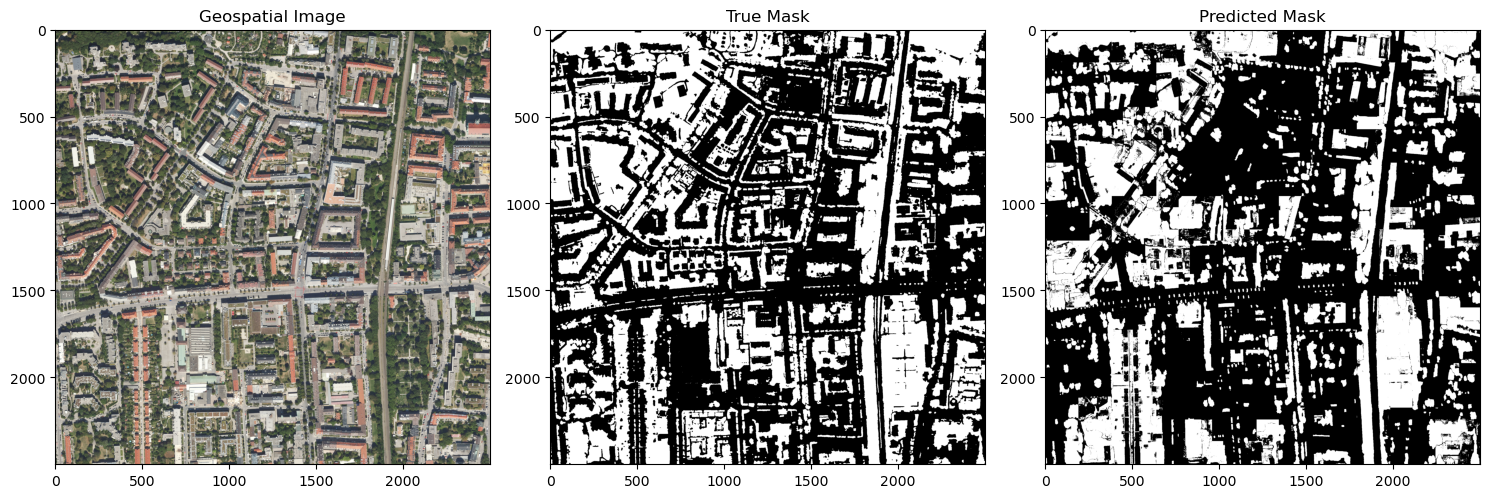

In [21]:
# show one image
file_name = train_files[0]

img_name = file_name.rstrip('.tif')
img_path = os.path.join(TRAIN_PATH, file_name)
mask_path = os.path.join(TRAIN_PATH, img_name + '_label.png')
predicted_path = os.path.join(PREDICTED_PATH, img_name + '_predicted.tif')
print(img_path, mask_path, predicted_path)

# plot 3 images first actual then label and predicted
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
predicted = cv2.imread(predicted_path)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Geospatial Image')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(predicted)
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()

In [18]:
import sys
sys.path.append('../mask-evaluation')
from main import print_metrics, evaluate_mask
from collections import Counter

In [19]:

data = []

for file_name in train_files:
    
    img_name = file_name.rstrip('.tif')
    img_path = os.path.join(TRAIN_PATH, file_name)
    mask_path = os.path.join(TRAIN_PATH, img_name + '_label.png')
    predicted_path = os.path.join(PREDICTED_PATH, img_name + '_predicted.tif')
    data.append((predicted_path, mask_path))
    

def evaluate_mask_file(base_mask_path: str, predicted_mask_path: str) -> Counter:
    expected = cv2.imread(base_mask_path)
    actual = cv2.imread(predicted_mask_path)
    return evaluate_mask(expected, actual)


res = sum([evaluate_mask_file(base, actual) for base, actual in data], Counter())

print_metrics(res)


Results: 
   accuracy: 87.669 %
         f1:  0.911
     recall:  0.935 (or sensitivity)
  precision:  0.889
specificity:  0.753

TPR: 0.935 | FNR: 0.065
TNR: 0.753 | FPR: 0.247
PPV: 0.889 | FDR: 0.111
NPV: 0.846 | FOR: 0.154


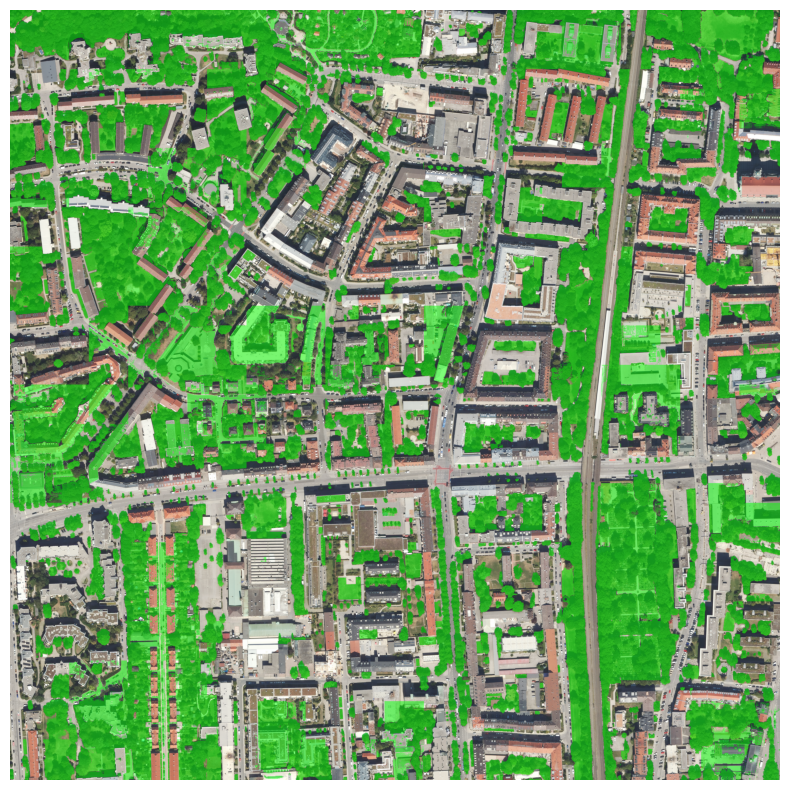

In [23]:
plot_overlay(img_path, predicted_path)